# Machine Learning Group Project 

User game rating prediction & systematic discount offering on Steam. Project developed by Team XX composed by:
| Student Name | Student Number | Class Group |
| --- | --- | --- |
| **Alessandro Maugeri** | 53067 | TA |
| **Frank Andreas Bauer** | XXXX | XX |
|  **Johannes Rahn** | 53958 | XX |
| **Nicole Zoppi** | XXXX | XX |
| **Yannick von der Heyden** | 53629 | TA |

## Importing Packages

In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Importing Data

The data for this project was retrieved from [Kaggle](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam?select=games.csv) and stored in the "data" folder found in the notebook's directory. The folder includes **four data files**:

The CSV file **[games.csv](data/games.csv)** presents data concerning individual games in the Steam library:

| Column | Description | Example|
| --- | --- | --- |
| **app_id** | Product ID on Steam | 620 |
| **title** | Product Commercial Title | Portal 2|
|  **date_release** | Release Date of Title (y-m-d) | 2011-04-18 |
| **win** | Boolean Denoting Compatibility to Windows Computers | True |
| **mac** | Boolean Denoting Compatibility to Mac Computers  | True | 
| **linux** | Boolean Denoting Compatibility to Linux Computers  | True |
| **rating** | Categorical Rating of Product (e.g. "Positive")| Overwhelmingly Positive |
| **positive_ratio** | Ratio of Postive Feedback for Game  | 98 |
| **user_reviews** | Number of Reviews  | 267142 |
| **price_final** | Final Price in USD | 9.99 |
| **price_original** | Price Before Discounts in USD | 9.99 |
| **discount** | Applied Discount | 0 |
| **steam_deck** | Discount Percentage | True |



In [39]:
df_games_data = pd.read_csv("data/games.csv")
df_games_data.head(2)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True


----
The **CSV file [users.csv](data/users.csv)** presents data concerning individual users found in the datasets:

| Column | Description | Example|
| --- | --- | --- |
| **user_id** | User ID on Steam | 5693478 |
| **products** | Number of Products from Steam Library Owned | 156 |
|  **reviews** | Number of Reviews Published | 1 |

In [3]:
df_users = pd.read_csv("data/users.csv")
df_users.head(2)

,user_id,products,reviews
0,5693478,156,1
1,3595958,329,3


----
The **CSV file [recommendations.csv](data/recommendations.csv)** has a many-to-many relationship to both users.csv and games.csv and contains data concerning user reviews of specific games:

| Column | Description | Example|
| --- | --- | --- |
| **app_id** | Product ID on Steam | 620 |
| **helpful** | Number of Users Who Found Review Helpful | 0 |
|  **funny** | Number of Users Who Found Review Funny | 0 |
| **date** | Date in Which Review was Published (y-m-d) | 2022-12-12 |
| **is_recommended** | Does the User Recommend the Title | True | 
| **hours** | Hours Spent by User Playing Game  | 36.3 |
| **user_id** | User ID of Review Author | 19954 |
| **review_id** | ID of Individual Review  | 0 |

In [4]:
df_redommendations = pd.read_csv("data/recommendations.csv")
df_redommendations.head(2)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,14546,0
1,304390,4,0,2017-02-17,False,11.5,797,1


----
Finally, the folder includes a **JSON file [games_metadata.json](data/games_metadata.json)** containing metadata on individual games:

| Column | Description | Example|
| --- | --- | --- |
| **app_id** | Product ID on Steam | 304430 |
| **description** | Game Description on Steam | "Hunted and alone, a boy finds himself drawn into the center of a dark project. INSIDE is a dark, narrative-driven platformer combining intense action with challenging puzzles. It has been critically acclaimed for its moody art style, ambient soundtrack and unsettling atmosphere." |
|  **tags** | Additional Tags on Steam Platform | ["2.5D", "Story Rich", "Puzzle Platformer" , "Atmospheric" , "Adventure" , "Indie" , "Dark" , "Horror" , "Singleplayer" , "Action-Adventure" , "Puzzle" , "Multiple Endings" , "Exploration" , "2D Platformer" , "Platformer" , "Controller" , "Soundtrack" , "Ambient" , "Action" , "Narrative"] |

In [5]:
df_games_meta_data = pd.read_json('data/games_metadata.json', lines=True)
df_games_meta_data.head(2)

,app_id,description,tags
0,10090,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."


## Preliminary Data Exploration

First, we look at the various values of the specific features of each file.

In [6]:
df_games_data.describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
app_id,46068.0,986443.12,567048.71,10.0,311867.0,501722.75,916285.00,1422157.50,1822837.00,2319990.00
positive_ratio,46068.0,76.76,18.20,0.0,50.0,66.00,81.00,91.00,96.00,100.00
user_reviews,46068.0,1843.20,39086.56,10.0,13.0,20.00,53.00,226.00,1186.00,6941137.00
price_final,46068.0,8.75,11.36,0.0,0.0,1.38,4.99,11.99,19.99,299.99
price_original,46068.0,9.30,11.67,0.0,0.0,1.99,5.99,12.99,19.99,299.99
discount,46068.0,5.19,18.19,0.0,0.0,0.00,0.00,0.00,0.00,90.00


In [7]:
df_users.describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
user_id,5810794.0,2905396.50,1677431.88,0.0,581079.3,1452698.25,2905396.5,4358094.75,5229713.7,5810793.0
products,5810794.0,132.25,262.36,0.0,8.0,23.00,62.0,151.00,306.0,29308.0
reviews,5810794.0,1.73,2.00,0.0,1.0,1.00,1.0,2.00,3.0,151.0


In [8]:
df_redommendations.describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
app_id,6126803.0,619681.31,505651.14,440.0,218620.0,255710.0,394360.0,1091500.0,1332010.0,2208920.0
helpful,6126803.0,3.47,65.33,0.0,0.0,0.0,0.0,0.0,3.0,29627.0
funny,6126803.0,1.24,47.99,-6.0,0.0,0.0,0.0,0.0,0.0,28088.0
hours,6126803.0,201.22,236.85,0.0,10.1,31.0,100.4,284.5,582.7,999.9
user_id,6126803.0,2165477.41,1216668.25,0.0,434576.2,1133890.0,2191020.0,3226141.0,3816665.8,4240752.0
review_id,6126803.0,3063401.00,1768655.83,0.0,612680.2,1531700.5,3063401.0,4595101.5,5514121.8,6126802.0


In [9]:
df_games_meta_data.describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
app_id,46068.0,986443.12,567048.71,10.0,311867.0,501722.75,916285.0,1422157.5,1822837.0,2319990.0


In [47]:
total_nans = df_redommendations.isna().sum().sum()
print(f"Total NaNs in the df_redommendations DataFrame: {total_nans}")

Total NaNs in the df_redommendations DataFrame: 0


In [48]:
total_nans = df_games_meta_data.isna().sum().sum()
print(f"Total NaNs in the df_games_meta_data DataFrame: {total_nans}")

Total NaNs in the df_games_meta_data DataFrame: 0


## Data Preparation

Below we prepare the individuals datasets for the analysis.

#### Games Data

In [10]:
# Turn date_release column to Pandas DateTime
df_games_data["date_release"] = pd.to_datetime(df_games_data["date_release"])

df_games_data["date_release"][0]

Timestamp('2008-11-18 00:00:00')

#### User Data

#### Recommendations Data

In [11]:
df_redommendations["date"] = pd.to_datetime(df_redommendations["date"])

#### Games Metadata

In [12]:
# Turn the Description Column to a String
df_games_meta_data['description'] = df_games_meta_data['description'].astype(str)

# Turn the Tags Column Into a List
df_games_meta_data["tags"] = df_games_meta_data["tags"].astype(str).apply(ast.literal_eval)

df_games_meta_data

,app_id,description,tags
0,10090,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,,[Action]
3,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...,...
46063,758560,"Welcome to Versus World! Shoot, stab, snipe, a...","[Action, Indie, Early Access, Gore, Violent, F..."
46064,886910,,"[Simulation, Free to Play, Multiplayer, Single..."
46065,1477870,Fire and Water what is that an online game mad...,"[Casual, Action, Adventure, Action-Adventure, ..."
46066,1638430,A modern turn-based deckbuilding JRPG involvin...,"[RPG, Pixel Graphics, Party-Based RPG, JRPG, A..."


## Merging Datasets

We merge the data into 

In [13]:
# Merge all information on games to one DataFrame
games_df = df_games_data.merge(df_games_meta_data)

# Merge game information into the recommendations DataFrame
recs_df = df_redommendations.merge(games_df, how = "left", on = "app_id")

# Merge all information on users into a final DataFrame
final_df = recs_df.merge(df_users, how="left", on = "user_id")

In [14]:
final_df.head(2)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,title,date_release,...,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,products,reviews
0,975370,0,0,2022-12-12,True,36.3,14546,0,Dwarf Fortress,2022-12-06,...,95,17773,29.99,29.99,0.0,True,"The deepest, most intricate simulation of a wo...","[Colony Sim, Indie, Pixel Graphics, Simulation...",24,0
1,304390,4,0,2017-02-17,False,11.5,797,1,FOR HONOR™,2017-02-13,...,68,76071,14.99,14.99,0.0,True,Carve a path of destruction through an intense...,"[Medieval, Swordplay, Action, Multiplayer, PvP...",40,1


## Data Exploration

In [146]:
final_df.shape

(3927522, 43)

In [147]:
total_nans = final_df.isna().sum().sum()
print(f"Total NaNs in the final_df DataFrame: {total_nans}")

Total NaNs in the final_df DataFrame: 15126


After merging all information into a final dataframe, we look at the various values of the specific features.

In [148]:
# describe final_df
final_df.describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
app_id,3927522.0,306037.7,161462.62,440.0,105600.0,239030.0,284160.0,386360.0,518790.0,960090.0
helpful,3927522.0,3.82,70.77,0.0,0.0,0.0,0.0,0.0,3.0,29627.0
funny,3927522.0,1.55,56.59,-6.0,0.0,0.0,0.0,0.0,0.0,28088.0
hours,3927522.0,246.07,258.38,0.0,12.0,42.4,143.5,378.9,673.1,999.9
user_id,3927522.0,2170676.04,1209458.83,0.0,439354.0,1168891.25,2192359.0,3211974.5,3819697.9,4240751.0
review_id,3927522.0,3063157.3,1768459.26,1.0,612957.2,1531722.75,3062826.0,4594579.75,5513936.9,6126800.0
positive_ratio,3927522.0,87.39,8.22,57.0,76.0,83.0,88.0,95.0,97.0,98.0
user_reviews,3927522.0,657700.2,1413045.69,1542.0,60168.0,120399.0,193409.0,572319.0,1367837.0,6941137.0
price_final,3927522.0,21.32,16.95,0.0,0.0,7.99,19.99,29.99,39.99,59.99
price_original,3927522.0,22.32,18.42,0.0,0.0,3.99,19.99,39.99,44.99,109.99


**Correlation Matrix**

/var/folders/gs/xnyw__p94xl1dp76b2zhm0yw0000gn/T/ipykernel_5004/575537364.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze['rating'] = df_analyze['rating'].map(rating_map)


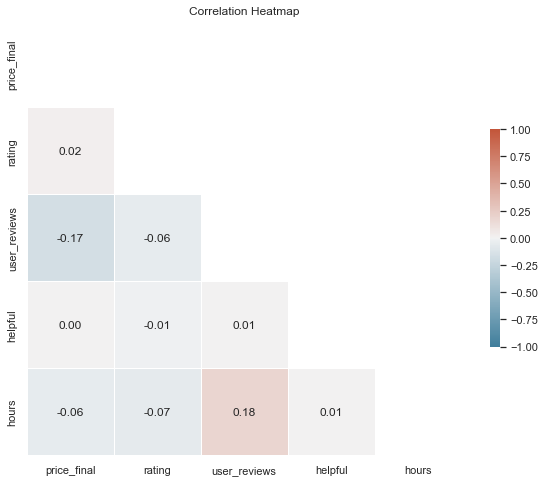

In [149]:
# correlations between different variables, such as price and rating, user reviews and helpful votes, or hours played and recommendation status.

import csv
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


df_analyze = final_df[['price_final', 'rating', 'user_reviews', 'helpful', 'hours']]

# Convert rating column to numerical values
rating_map = {
    'Overwhelmingly Positive': 5,
    'Very Positive': 4,
    'Mostly Positive': 3,
    'Mixed': 2,
    'Mostly Negative': 1,
    'Very Negative': 0
}
df_analyze['rating'] = df_analyze['rating'].map(rating_map)

# Convert is_recommended column to binary values
#df_analyze['is_recommended'] = df_analyze['is_recommended'].map({True: 1, False: 0})

# Calculate the correlation matrix
corr_matrix = df_analyze.corr()

# Setting seaborn style
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(10, 8))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


As expected, be observe the strongest positive correlations between is_recommended and rating and user_reviews and hours. Hours and is_recommended are also slightly correlated.
The final price seems to have a negative influence on user_reviews and the rating.

**Frequency Distribution of Final Prices**

<Figure size 720x360 with 0 Axes>

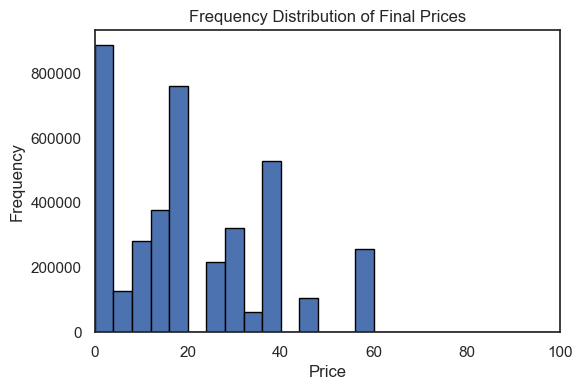

In [150]:
# frequency distribution of final prices

plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.hist(final_df['price_final'], bins=25, edgecolor='black', range=(0, 100))
plt.title('Frequency Distribution of Final Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Set the x-axis limits to 0 and 110
plt.show()

**Boxplot of Final Prices**

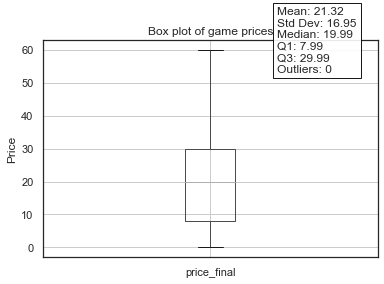

In [151]:
# boxplot of final price

ax = final_df.boxplot('price_final')

ax.set_ylabel('Price')
ax.set_title('Box plot of game prices')

stats = final_df['price_final'].describe()
mean = final_df['price_final'].mean()
std_dev = final_df['price_final'].std()

# calculate outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = final_df[(final_df['price_final'] < lower_bound) | (final_df['price_final'] > upper_bound)]['price_final']
num_outliers = outliers.count()

# add statistics to the plot
ax.text(0.7, 0.85, f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMedian: {stats['50%']:.2f}\nQ1: {stats['25%']:.2f}\nQ3: {stats['75%']:.2f}\nOutliers: {num_outliers}",
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))


plt.show()


**Frequency Distribution of Rating**

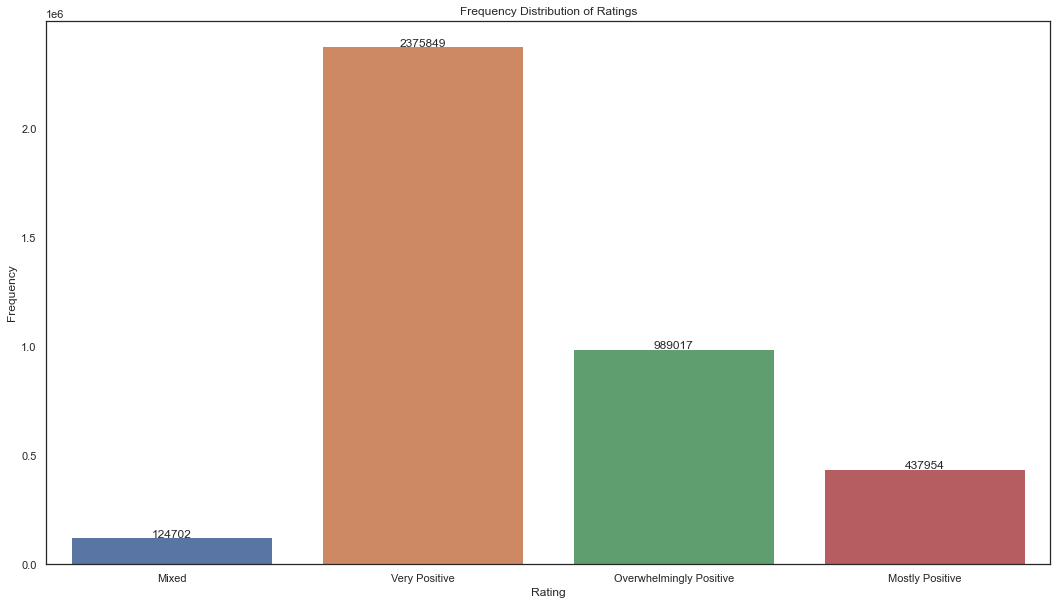

In [152]:
# Plotting the frequency distribution of rating

plt.figure(figsize=(18, 10))
ax = sns.countplot(x='rating', data=final_df)
plt.title('Frequency Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

**Frequency Distribution of Recommendations**

**Compatibility of Windows, Mac and Linux**

In [ ]:
# compatibility with different platforms

# Calculating the number of games compatible with each platform
platform_counts = final_df[['win', 'mac', 'linux']].sum().reset_index()
platform_counts.columns = ['Platform', 'Count']

plt.figure(figsize=(10, 5))

ax = sns.barplot(x='Platform', y='Count', data=platform_counts)
plt.title('Number of Games Compatible with Different Platforms')
plt.xlabel('Platform')
plt.ylabel('Number of Games')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()


In [ ]:
# Calculate the number of games supporting each combination of platforms (windows, mac, linux)

win_only = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == False)).sum()
win_mac = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
win_linux = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()
win_mac_linux = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == True)).sum()
mac_only = ((final_df['win'] == False) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
linux_only = ((final_df['win'] == False) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()

print(f"Number of games supporting only Windows: {win_only}")
print(f"Number of games supporting Windows and Mac: {win_mac}")
print(f"Number of games supporting Windows and Linux: {win_linux}")
print(f"Number of games supporting Windows, Mac, and Linux: {win_mac_linux}")
print(f"Number of games supporting only Mac: {mac_only}")
print(f"Number of games supporting only Linux: {linux_only}")

In [ ]:
# Platform combinations and their counts

platform_combinations = {
    "Windows Only": win_only,
    "Windows & Mac": win_mac,
    "Windows & Linux": win_linux,
    "Windows, Mac & Linux": win_mac_linux,
    "Mac Only": mac_only,
    "Linux Only": linux_only,
}

fig, ax = plt.subplots()
ax.bar(platform_combinations.keys(), platform_combinations.values())

# Add the counts above the bars
for i, (combination, count) in enumerate(platform_combinations.items()):
    ax.text(i, count + 10, f"{count}", ha='center', va='bottom')

ax.set_title("Number of Games Supporting Platform Combinations")
ax.set_xlabel("Platform Combinations")
ax.set_ylabel("Number of Games")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Windows definitly dominates, when it comes to the number of games it supports. Most developers only develop for windows. However, there are still many games which run on windows, mac and linux. These results tell us that we should consider a users operating system, when recommending a game based on a user_id.

**Most popular Tags**

In [ ]:
# Most common tags, and the impact of tags on game popularity and sales (prices and discounts)

from collections import Counter

# Extract tags and genres
tags = final_df['tags'].explode().dropna()

# Count occurrences of each tag and genre
tag_counts = Counter(tags)

# Find most common tags
most_common_tags = tag_counts.most_common(10)
print('\n'"Most common tags:", most_common_tags)

# Analyze the impact of tags on game popularity and sales
tag_popularity = final_df.explode('tags').groupby('tags').agg({
    'user_reviews': 'mean',
    'positive_ratio': 'mean',
    'price_final': 'mean',
    'price_original': 'mean',
    'discount': 'mean'
}).sort_values(by='user_reviews', ascending=False)

print('\n'"Impact of tags on game popularity, and sales:")
tag_popularity.head(10)


Games with the tags "action", "singleplayer", "multiplayer", "co-op" and "adventure" are the most popular ones based on the number of tags. 

We also observe the impact of tags on game popularity and sales. 
The tag "trading" leads to the most user_reviews. Games with the tags "military" and "war" have the highest average final price and original price. Games with the tags "war" and "tactical" have the highest average discount.

**Trends in game releases, user reviews, and ratings over time**

In [ ]:
# Trends in game releases, user reviews, and ratings over time

final_df['date_release'] = pd.to_datetime(final_df['date_release'])
final_df['date'] = pd.to_datetime(final_df['date'])

game_releases_by_year = final_df.groupby(final_df['date_release'].dt.year).size()
user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].sum()
avg_ratings_by_year = final_df.groupby(final_df['date'].dt.year)['positive_ratio'].mean()

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Game Releases', color='tab:blue')
ax1.plot(game_releases_by_year.index, game_releases_by_year, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('User Reviews', color='tab:red')
ax2.plot(user_reviews_by_year.index, user_reviews_by_year, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Game Releases and User Reviews Over Time')
plt.show()

plt.plot(avg_ratings_by_year.index, avg_ratings_by_year)
plt.xlabel('Year')
plt.ylabel('Average Ratings')
plt.title('Average Ratings Over Time')
plt.show()


On average, the number of game releases has increased from 2006 to 2022. There where several drop in 2013, 2018 and 2020. The last drop is most likely due to the Covid-19 pandemic. User started reviewing games since 2010. The number of reviews has strongly increased since then.

The average ratings over time have decreased from 93 in the year 2010 to a rating of 84 in the year 2022. This could potentially indicate that the quality in games has also decreased and user are less satisfied with their games.

## Feature Engineering

**Elapsed Time:** A new feature which tracks the amount of time that has elapsed between the game's release and the review being logged. This could be interested because people who purchase a game right after its release are likely to be larger fans of the genre or franchise.

In [ ]:
final_df["elapsed_time"] = final_df["date"] - final_df["date_release"]

**Relative Recommendation:** Likelihood 

In [13]:
usr_avg_rating = final_df[["user_id","is_recommended"]].groupby("user_id").mean()
usr_avg_rating.rename(columns = {"is_recommended":"avg_rating"}, inplace = True)

In [14]:
final_df = final_df.merge(usr_avg_rating, how = "left", on = "user_id")
final_df["rel_rec"] = (final_df["is_recommended"] - final_df["avg_rating"])

In [154]:
final_df

,app_id,helpful,funny,date,y,hours,user_id,review_id,title,date_release,...,products,reviews,elapsed_time,review_count,positive_rate,relaitve_rec,review_tendency,rel_review_tendency,positive_reviews,negative_reviews
0,304390,4,0,2017-02-17,False,11.5,797,1,FOR HONOR™,2017-02-13,...,40,1,4 days,1,0.000000,0.000000,0.025000,0.025000,5172828,-5096757
1,304390,2,0,2017-03-23,False,180.6,103506,26,FOR HONOR™,2017-02-13,...,10,1,38 days,2,0.000000,0.000000,0.100000,3.100000,5172828,-5096757
2,108600,0,0,2022-01-17,False,132.2,103506,2349574,Project Zomboid,2013-11-08,...,10,1,2992 days,2,0.000000,0.000000,0.100000,3.100000,12226059,-12094596
3,304390,0,0,2017-02-25,False,5.0,2862957,191,FOR HONOR™,2017-02-13,...,103,1,12 days,1,0.000000,0.000000,0.009709,-0.601942,5172828,-5096757
4,304390,4,0,2021-04-25,False,42.5,3094839,203,FOR HONOR™,2017-02-13,...,444,2,1532 days,3,0.333333,-0.333333,0.004505,-0.815315,5172828,-5096757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927517,268910,201,15,2018-10-27,True,14.2,3203206,4133182,Cuphead,2017-09-29,...,20,1,393 days,1,1.000000,0.000000,0.050000,1.050000,11126304,-11010405
3927518,268910,411,140,2022-02-10,True,13.9,2909967,4181242,Cuphead,2017-09-29,...,90,3,1595 days,1,1.000000,0.000000,0.033333,0.366667,11126304,-11010405
3927519,268910,127,84,2022-08-11,True,7.8,2775988,5401104,Cuphead,2017-09-29,...,50,1,1777 days,1,1.000000,0.000000,0.020000,-0.180000,11126304,-11010405
3927520,268910,254,11,2017-09-29,True,1.9,2745475,5973191,Cuphead,2017-09-29,...,102,1,0 days,1,1.000000,0.000000,0.009804,-0.598039,11126304,-11010405
